In [5]:
import requests
from bs4 import BeautifulSoup as BS
import requests
import json
import mysql.connector
import pandas as pd
import config
import seaborn as sns

db = mysql.connector.connect(
    host = config.host,
    user = config.user,
    password = config.password,
    database = "youtube")

cursor = db.cursor()

# Database and Table Creation

In [274]:
#create database
from mysql.connector import errorcode
db_name = 'youtube'

def create_database(cursor, database):
    try:
        cursor.execute(
            "CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(database))
    except mysql.connector.Error as err:
        print("Failed creating database: {}".format(err))
        exit(1)

try:
    cursor.execute("USE {}".format(db_name))
except mysql.connector.Error as err:
    print("Database {} does not exists.".format(db_name))
    if err.errno == errorcode.ER_BAD_DB_ERROR:
        create_database(cursor, db_name)
        print("Database {} created successfully.".format(db_name))
        cnx.database = db_name
    else:
        print(err)
        exit(1)
        
# create_database(cursor, db_name)

Failed creating database: 1007 (HY000): Can't create database 'youtube'; database exists


In [17]:
#Create table for channel data only

db_name = 'youtube'

create_query = """
CREATE TABLE channels (
    channel_id varchar(40) NOT NULL, 
    channel_title varchar(60) NOT NULL UNIQUE, 
    creation_date datetime, 
    country varchar(20), 
    view_count bigint NOT NULL,
    comment_count int,
    subscriber_count int NOT NULL,
    video_count int NOT NULL,
    CONSTRAINT primary_key PRIMARY KEY(channel_id)
    );

"""
# cursor.execute(create_query)


In [88]:
#create table for the genre and channel ids
create_query = """
      CREATE TABLE genres
    (
      genre_name varchar(50),
      channel_id varchar(40) NOT NULL, 
      FOREIGN KEY (channel_id) REFERENCES channels(channel_id)  
      )
    """
# cursor.execute(create_query)

# Import CSV of Youtube Channel Names

#Clean and Import Top Channel Names:

In [6]:
#Import top 500 channel names csv 
all_titles = pd.read_csv('Workbook1.csv', encoding = "ISO-8859-1")
column_names = ['channel']
all_titles.columns = [x for x in column_names]
all_titles['channel'] = all_titles['channel'].str.rstrip('æ')


In [7]:
#Import and final clean API output csv
first_channels = pd.read_csv("channel_set_final.csv")
channels_df = first_channels.drop(columns = 'genres')
channels_df2 = channels_df.fillna(value='Null')
first_channels_dict = channels_df2.to_dict(orient='records')


# INSERT to MySQL

In [92]:
#Insert function for all channel data

def insert_channel(parsed_channels_data):
    """
    Inserts parsed_channel_data into the channels table in the youtube MySQL database.
    """
    
    channel_tuples = [(parsed_channel_data['channel_id'],
                     parsed_channel_data['channel_title'],
                     parsed_channel_data['creation_date'],
                     parsed_channel_data['country'],
                     parsed_channel_data['view_count'],
                     parsed_channel_data['comment_count'],
                     parsed_channel_data['subscriber_count'],
                     parsed_channel_data['video_count']) for parsed_channel_data in parsed_channels_data]
#     for single_tuple in channel_tuples:    
#         print(single_tuple[4])
    insert_statement = """
        INSERT INTO channels 
            (channel_id, 
            channel_title, 
            creation_date, 
            country, 
            view_count,
            comment_count,
            subscriber_count,
            video_count
            )
            
        VALUES
            (%s, %s, %s, %s, %s, %s, %s, %s);"""
    
        
    cursor.executemany(insert_statement,channel_tuples)
    db.commit()
    
insert_channel(first_channels_dict)

# cursor.close()
# db.close()

In [94]:
#Find unique genres
#find genre_channels tuple with channel id 

genres_only = first_channels[['channel_id','genres']]

def separate_genres(genres_only):
    genres_list = []
    genre_channel_tuples = []
    for index, genres in genres_only['genres'].items():
        cleaned_genres = genres.replace("[", "").replace("]", "").replace("'", "")
        splt_genres = cleaned_genres.split(", ")
        
        for item in splt_genres:
            genres_list.append(item)
            tuple_ = genres_only['channel_id'][index], item
            genre_channel_tuples.append(tuple_)
    
    return (set(genres_list)), genre_channel_tuples

unique_genres, genre_channels_tuples = separate_genres(genres_only)


1171

In [41]:
#Dictionary and df of genres only
genres_dict = genres_only.to_dict(orient='records')
unique_genres_df = pd.DataFrame(unique_genres,columns=['genre'])

In [95]:
#insert genres and channel ids into mysql using the genre tuples

def insert_genre(genre_data):

    insert_statement = """
        INSERT INTO genres
            (channel_id,
            genre_name 
            )
            
        VALUES
            (%s, %s);"""
        
    cursor.executemany(insert_statement, genre_data)
    db.commit()
    
insert_genre(genre_channels_tuples)



In [19]:
# cursor.close()
# db.close()


# Query from MySQL

In [51]:
#Query for all channel data
cursor = db.cursor()

channel_info = cursor.execute("""SELECT * FROM youtube.channels""")
channel_info = pd.DataFrame(cursor.fetchall())
channel_info.columns = [x[0] for x in cursor.description]
channel_info.head()

,channel_id,channel_title,creation_date,country,view_count,comment_count,subscriber_count,video_count
0,UC-4kjzuh4822B9yPSgpZQgA,Matheus Yurley,2015-01-27 00:37:14,BR,595750608,0,11600000,209
1,UC-8Q-hLdECwQmaWNwXitYDw,KatyPerryVEVO,2009-12-13 03:04:53,US,18376186831,0,25900000,136
2,UC-J-KZfRV8c13fOCkhXdLiQ,Dua Lipa,2011-02-05 14:36:44,GB,3881487039,0,11400000,93
3,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,2010-04-29 10:54:00,US,23936169110,0,102000000,4010
4,UC-LPIU24bQXVljUXivKEeRQ,StarPlus,2006-05-19 21:46:13,Null,3223274932,0,10500000,8905


GENRE IMPORT

In [50]:
#Query for genre info from MySQL

cursor = db.cursor()
genre_info = cursor.execute("""SELECT * FROM youtube.genres""")
genre_info = pd.DataFrame(cursor.fetchall())
genre_info.columns = [x[0] for x in cursor.description]

GENRES AND CHANNELS - Join

In [49]:
#Channel and Genre information from MySQL

cursor = db.cursor()
genre_channel_info = cursor.execute("""SELECT * FROM channels JOIN genres USING(channel_id)""")
genre_channel_info = pd.DataFrame(cursor.fetchall())
genre_channel_info.columns = [x[0] for x in cursor.description]
# genre_channel_info.head()

In [36]:
#Groupby query for genre data visualization
genre_channel_info = cursor.execute("""
                    SELECT 
                    gr.genre_name,
                    AVG(ch.view_count), 
                    AVG(ch.video_count), 
                    AVG(ch.subscriber_count), 
                    COUNT(gr.genre_name) 
                    FROM 
                    youtube.channels ch 
                    JOIN 
                    youtube.genres gr 
                    ON 
                    ch.channel_id = gr.channel_id
                    GROUP BY 
                    genre_name
                    ORDER BY COUNT(gr.genre_name) DESC
                    """)

genre_avg_table = pd.DataFrame(cursor.fetchall())
genre_avg_table.columns = [x[0] for x in cursor.description]


# Statistical Analysis


$$H_0: \text {All genres are equally likely to be in top channels}$$
$$𝐻0=𝜇1=𝜇1=𝜇3$$

$$H_1: \text {Not all genres are equally likely to be in top channels}$$ 
$$𝐻𝑎  \text { :H0 is not true}$$




ONE-WAY ANOVA:

Independent variable is discrete.
Dependendent variable should be continuous.


In [56]:
#Cutting the genres to TOP 3
s = genre_channel_info['genre_name'].value_counts()
new_genre_channel = genre_channel_info[genre_channel_info.isin(s.index[s >100]).values]
new_genre_channel['genre_name'].value_counts()

all_genres = genre_channel_info[genre_channel_info.isin(s.index[s >5]).values]

new_genre_channel.head()

,channel_id,channel_title,creation_date,country,view_count,comment_count,subscriber_count,video_count,genre_name
0,UC-4kjzuh4822B9yPSgpZQgA,Matheus Yurley,2015-01-27 00:37:14,BR,595750608,0,11600000,209,Entertainment
1,UC-4kjzuh4822B9yPSgpZQgA,Matheus Yurley,2015-01-27 00:37:14,BR,595750608,0,11600000,209,Lifestyle (Sociology)
4,UC-8Q-hLdECwQmaWNwXitYDw,KatyPerryVEVO,2009-12-13 03:04:53,US,18376186831,0,25900000,136,Music
5,UC-J-KZfRV8c13fOCkhXdLiQ,Dua Lipa,2011-02-05 14:36:44,GB,3881487039,0,11400000,93,Music
8,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,2010-04-29 10:54:00,US,23936169110,0,102000000,4010,Entertainment


In [18]:
#Create Anova Table for Genres and View_Counts
# 'view_count~genre_name'
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import norm

def run_anova_table(dependent, independent, data_):  
    genre_stats = ols(f"{dependent}~{independent}", data=data_).fit()  
    anova_table = sm.stats.anova_lm(genre_stats, type=2)
    
    return  genre_stats.summary(), anova_table


In [19]:
#ALL ANOVA TESTS FOR GENRES

#view count ANOVA summary and ANOVA table
view_count_summary, view_count_table = run_anova_table('view_count', 'genre_name', new_genre_channel)

#subscriber count ANOVA summary and ANOVA table
subscriber_count_summary, subscriber_count_table = run_anova_table('subscriber_count', 'genre_name', new_genre_channel)

#video count ANOVA summary and ANOVA table
video_count_summary, video_count_table = run_anova_table('video_count', 'genre_name', new_genre_channel)

view_count_table

,df,sum_sq,mean_sq,F,PR(>F)
genre_name,2.0,7.503947e+20,3.751974e+20,6.110712,0.002373
Residual,548.0,3.364717e+22,6.139995e+19,NaN,NaN


In [20]:
#Perform a post-hoc test on the data to detemine all comparisons
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

def get_tukey(dependent, independent):
# Set up the data for comparison (creates a specialised object)
    MultiComp = MultiComparison(new_genre_channel[dependent],
                            new_genre_channel[independent])
    
    return MultiComp.tukeyhsd().summary()

In [22]:
#ALL TUKEY TESTS FOR GENRES

#post_hoc comparison for view_counts and genres - not significant
view_count_tukey = get_tukey('view_count', 'genre_name')

#post_hoc comparison for subscriber counts and genres - not significant
subscriber_count_tukey = get_tukey('subscriber_count', 'genre_name')

# post_hoc comparison for video counts and genres - significant
video_count_tukey = get_tukey('video_count', 'genre_name')

subscriber_count_tukey

group1,group2,meandiff,p-adj,lower,upper,reject
Entertainment,Lifestyle (Sociology),-3079794.6374,0.0252,-5853773.8588,-305815.416,True
Entertainment,Music,642215.6718,0.8131,-1967896.7891,3252328.1328,False
Lifestyle (Sociology),Music,3722010.3092,0.0083,792485.3427,6651535.2757,True


In [23]:
video_count_tukey

group1,group2,meandiff,p-adj,lower,upper,reject
Entertainment,Lifestyle (Sociology),-4391.0092,0.0121,-7993.8225,-788.1959,True
Entertainment,Music,-4637.4395,0.0039,-8027.4245,-1247.4545,True
Lifestyle (Sociology),Music,-246.4303,0.9,-4051.2647,3558.4041,False


In [24]:
view_count_tukey

group1,group2,meandiff,p-adj,lower,upper,reject
Entertainment,Lifestyle (Sociology),-2038734277.506,0.0389,-3995660772.9436,-81807782.0685,True
Entertainment,Music,998910057.3494,0.4116,-842415281.9031,2840235396.602,False
Lifestyle (Sociology),Music,3037644334.8555,0.0017,970986812.051,5104301857.6599,True


In [45]:
#Manually running a ONE-WAY ANOVA to make sure the other is operating correctly
import statsmodels.api as sm
import scipy.stats as stats
stats.f_oneway(new_genre_channel['view_count'][new_genre_channel['genre_name'] == 'Entertainment'], 
             new_genre_channel['view_count'][new_genre_channel['genre_name'] == 'Lifestyle (Sociology)'],
             new_genre_channel['view_count'][new_genre_channel['genre_name'] == 'Music'])

F_onewayResult(statistic=6.110711515651967, pvalue=0.0023730770534201267)

In [46]:
#Regression Analysis for Video Count and View Count

def run_regression(dependent, independent, data_):  
    genre_stats = ols(f"{dependent}~{independent}", data=data_).fit()  
    p = genre_stats.f_pvalue
    return genre_stats.summary(), p

run_regression('view_count', 'video_count', channel_info)


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:             view_count   R-squared:                       0.043
 Model:                            OLS   Adj. R-squared:                  0.041
 Method:                 Least Squares   F-statistic:                     17.96
 Date:                Tue, 19 Nov 2019   Prob (F-statistic):           2.81e-05
 Time:                        08:57:16   Log-Likelihood:                -9579.9
 No. Observations:                 397   AIC:                         1.916e+04
 Df Residuals:                     395   BIC:                         1.917e+04
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
 --------------------------------------------------------------------

In [47]:
#Looking at regression output for viewcount and videocount
video_count_t = 8.61/2.03
t_square= 4.238**2
p_value = 2.8125388045932456e-05


# Plotting

Data Visualizations for Analytics


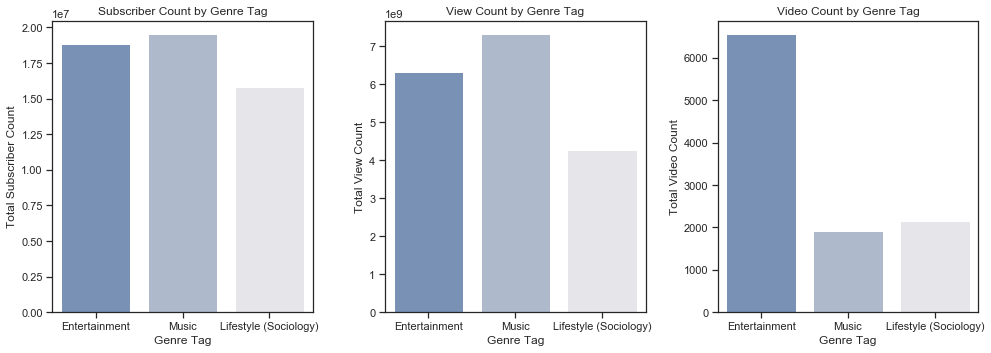

In [41]:
#Visualization of Subscriber Count, View Count, and Video Count by Genre
test = genre_avg_table.head(3)

grid = (3,3) # Make a 2x2 axis grid to plot four plots in the same figure
fig = plt.figure(figsize=(14,14))
ax1 = plt.subplot2grid(grid, (0,0)) # First ax in position (0,0) (top left)
ax2 = plt.subplot2grid(grid, (0,1)) # Second ax in position (0,1) (top right)
ax3 = plt.subplot2grid(grid, (0,2)) # Third ax in position (1,0) (bottom left)


sns.barplot(x=test['genre_name'],y =test['AVG(ch.subscriber_count)'], ax=ax1)
ax1.set_title('Subscriber Count by Genre Tag');
ax1.set_xlabel('Genre Tag'), ax1.set_ylabel('Total Subscriber Count');

sns.barplot(x=test['genre_name'],y =test['AVG(ch.view_count)'], ax=ax2)
ax2.set_title('View Count by Genre Tag');
ax2.set_xlabel('Genre Tag'), ax2.set_ylabel('Total View Count');

sns.barplot(x=test['genre_name'],y =test['AVG(ch.video_count)'], ax=ax3)
ax3.set_title('Video Count by Genre Tag');
ax3.set_xlabel('Genre Tag'), ax3.set_ylabel('Total Video Count');

# plt.setp(axes, yticks=[])
plt.tight_layout()

[Text(0, 0.5, 'Channel Genre Tag'),
 Text(0.5, 0, 'Subscriber Count(Millions)'),
 Text(0.5, 1.0, 'Subscriber Count by Genre Tag')]

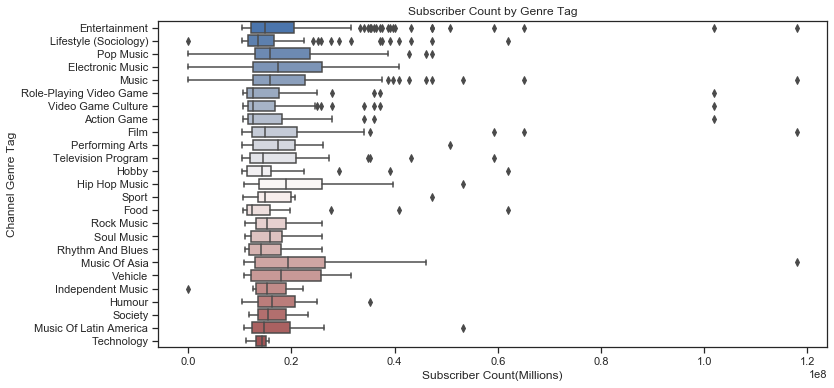

In [53]:
#Visualization of Genre Tag and Subscriber Counts
plt.figure(figsize=(12, 6))

sns.set(style="ticks", palette="vlag")

genre_plot = sns.boxplot(x = all_genres['subscriber_count'], y=all_genres['genre_name'], palette="vlag")
clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
genre_plot.set(xlabel = "Subscriber Count(Millions)", ylabel='Channel Genre Tag', title='Subscriber Count by Genre Tag')


[Text(0, 0.5, 'Channel Genre Tag'),
 Text(0.5, 0, 'View Count (Billions)'),
 Text(0.5, 1.0, 'View Count by Genre Tag')]

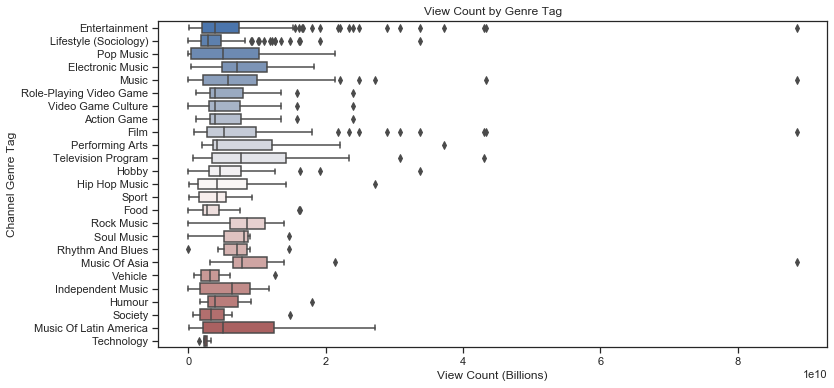

In [54]:
#Visualization of view counts and genre tags

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(12, 6))

sns.set(style="ticks", palette="vlag")

genre_plot = sns.boxplot(x = all_genres['view_count'], y=all_genres['genre_name'], palette="vlag")
clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
genre_plot.set(xlabel = "View Count (Billions)", ylabel='Channel Genre Tag', title='View Count by Genre Tag')
